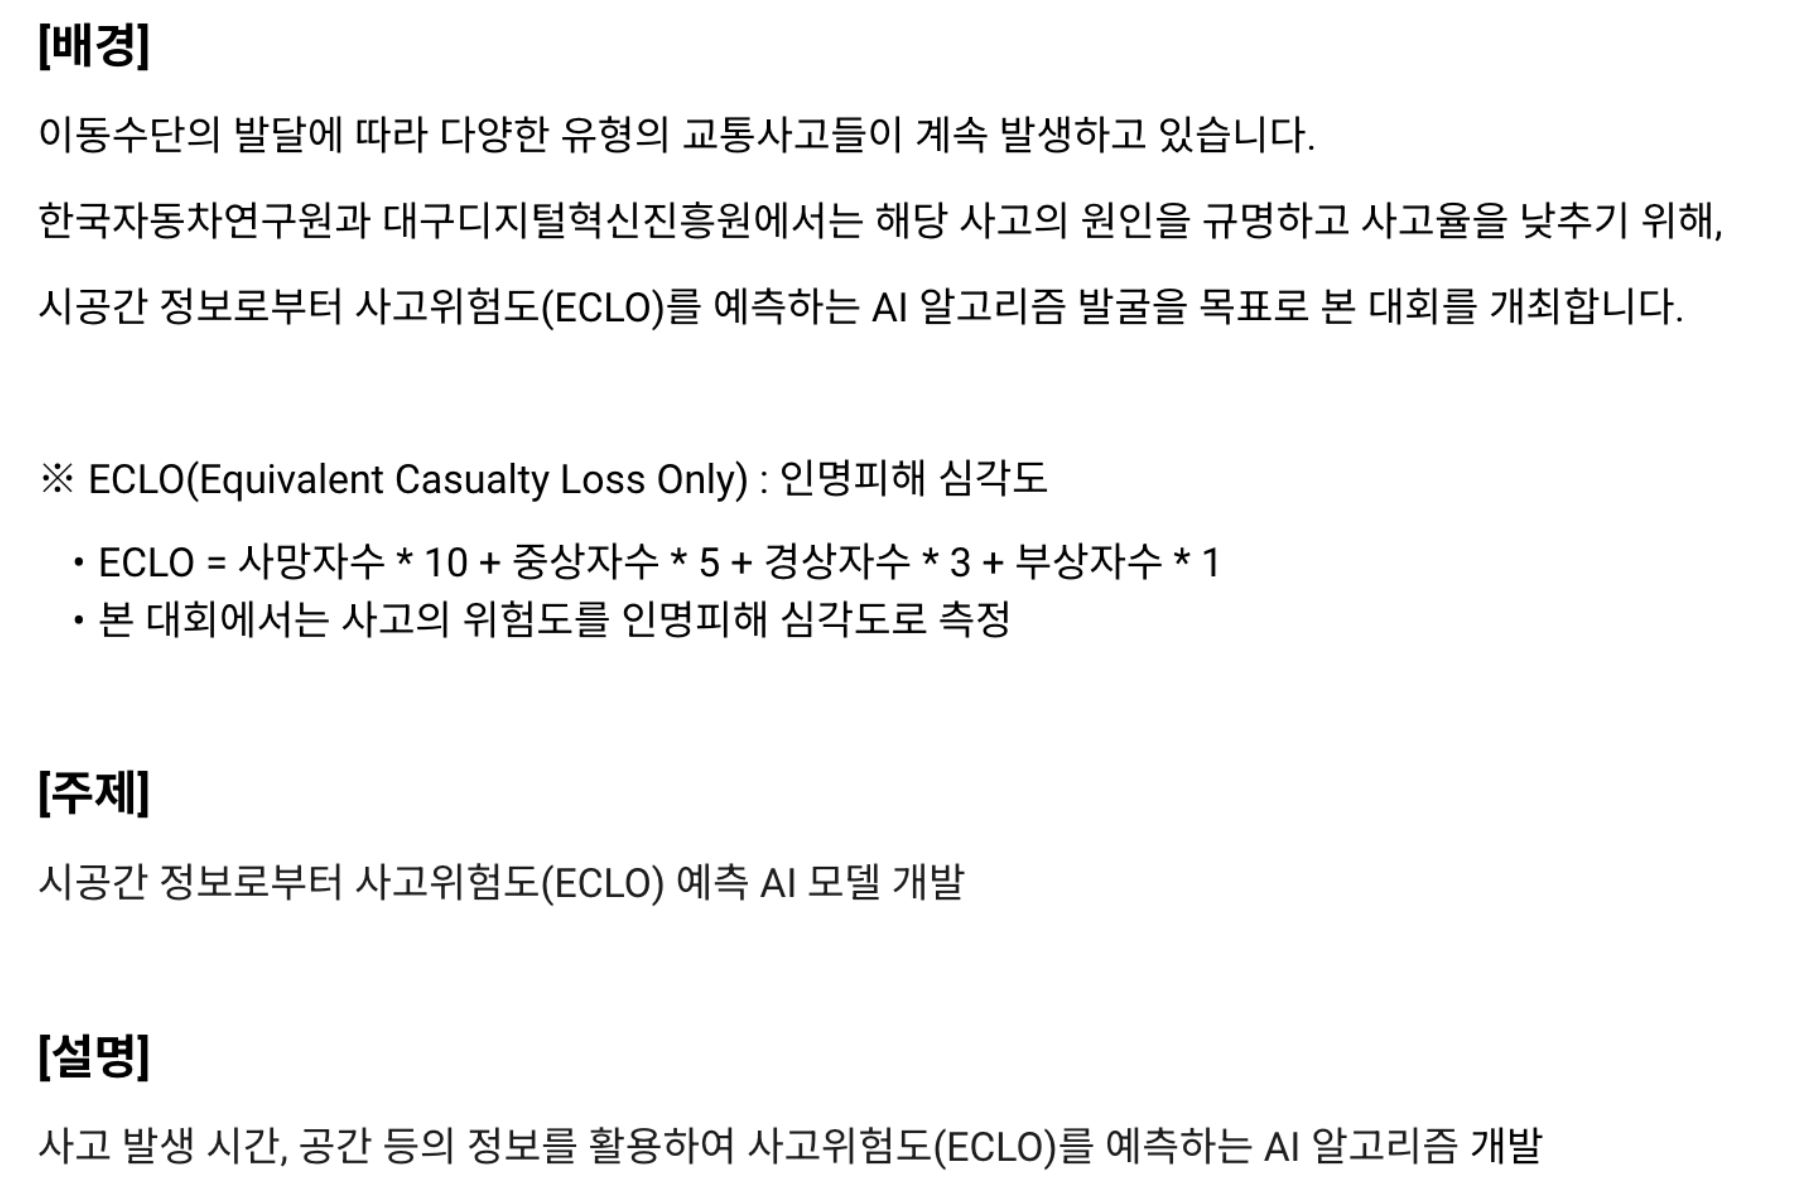

### 패키지

In [73]:
import random
import os

import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic') # mac 한글 설정
plt.rcParams['axes.unicode_minus'] == False

# ignore warning message
import warnings
warnings.filterwarnings('ignore')

# data preprocessing
from sklearn.model_selection import train_test_split

# model pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler , OneHotEncoder
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import XGBRegressor


pd.set_option('display.max_columns', None)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 데이터 불러오기 

- 데이터를 불러올때 test 제출기회가 하루에 3번이므로 최대한 활용하기 위해서 train validation test 로 나눠서 test 성능이 제일 좋으면 제출해보도록 하겠다.

- 비율은 train : validation : test = 60 : 20 : 20 으로 설정하겠다.

In [67]:
# import data
train_dataset = pd.read_csv('./train.csv', encoding = 'utf-8')
predict_dataset = pd.read_csv('./test.csv', encoding= 'utf-8')

# # Split X , y data
# y_train = train_dataset[['ECLO']]
# X_train = train_dataset.drop(['ECLO'], axis=1)

# # split train, validation dataset
# print(train_dataset.shape)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=SEED)

# print('split train, validation dataset')
# print(X_test.shape, y_test.shape)
# print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)


In [68]:
# ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형 여기서 만들 수 있는 파생변수를 제외하고는 사용하지 못함
# 위는 test dataset의 column 명

In [69]:
# ID 제거
train = train_dataset.copy()
predict = predict_dataset.copy()


## ID 제거
train.drop(['ID'] , axis = 1, inplace = True)
predict.drop(['ID'] , axis = 1, inplace = True)

print(train.columns , '\n',  predict.columns)

## 외부 데이터를 이용하면 사고유형-세부분류를 예측할 수 있을 것으로 보인다.

# 우선 사고유형 - 세부분류 삭제
train.drop(['사고유형 - 세부분류'] , axis = 1, inplace = True)

# predict dataset 과 연관이 없어 보이는 데이터 삭제
train.drop(['법규위반','가해운전자 차종','가해운전자 성별','가해운전자 연령','가해운전자 상해정도','피해운전자 차종','피해운전자 성별','피해운전자 연령','피해운전자 상해정도'], inplace = True , axis = 1)
display(train.head())
display(predict.head())

print("---- 사고일시 년, 월, 일, 시간 분리 ----")
time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train[['연','월','일','시간']] = train_dataset['사고일시'].str.extract(time_pattern)
train[['연','월','일','시간']] = train[['연','월','일','시간']].apply(pd.to_numeric)
train.drop(['사고일시'], axis = 1 , inplace = True)

predict[['연','월','일','시간']] = predict_dataset['사고일시'].str.extract(time_pattern)
predict[['연','월','일','시간']] = predict[['연','월','일','시간']].apply(pd.to_numeric)
predict.drop(['사고일시'], axis = 1 , inplace = True)

display(train.head())
display(predict.head())


print("---- 시군구에서 시 삭제, 군 구 구분 ----")
location_pattern = r'(\S+) (\S+) (\S+)'

train[['시', '구','동']] = train_dataset['시군구'].str.extract(location_pattern)
train.drop(['시', '시군구'], axis = 1 , inplace = True)

predict[['시', '구','동']] = predict_dataset['시군구'].str.extract(location_pattern)
predict.drop(['시', '시군구'], axis = 1 , inplace = True)

display(train.head())
display(predict.head())

print("---- 사, 중, 경, 부 삭제 ----")
train.drop(['사망자수','중상자수','경상자수','부상자수'], axis = 1 , inplace = True)

display(train.head())
display(predict.head())

print(f"---- 최종 데이터 모양 ----")
display(train.head())
display(predict.head())

Index(['사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',
       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',
       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',
       'ECLO'],
      dtype='object') 
 Index(['사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형'], dtype='object')


,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO
0,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,0,1,0,0,5
1,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,0,0,1,0,3
2,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,0,0,1,0,3
3,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,0,1,0,0,5
4,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,0,0,1,0,3


,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
0,2022-01-01 01,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람
1,2022-01-01 01,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람
2,2022-01-01 04,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차
3,2022-01-01 04,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차
4,2022-01-01 06,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차


---- 사고일시 년, 월, 일, 시간 분리 ----


,요일,기상상태,시군구,도로형태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간
0,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,0,1,0,0,5,2019,1,1,0
1,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,0,0,1,0,3,2019,1,1,0
2,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,0,0,1,0,3,2019,1,1,1
3,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,0,1,0,0,5,2019,1,1,2
4,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,0,0,1,0,3,2019,1,1,4


,요일,기상상태,시군구,도로형태,노면상태,사고유형,연,월,일,시간
0,토요일,맑음,대구광역시 수성구 상동,교차로 - 교차로안,건조,차대사람,2022,1,1,1
1,토요일,맑음,대구광역시 수성구 지산동,단일로 - 기타,건조,차대사람,2022,1,1,1
2,토요일,맑음,대구광역시 수성구 수성동2가,교차로 - 교차로안,건조,차대차,2022,1,1,4
3,토요일,맑음,대구광역시 수성구 신매동,단일로 - 기타,건조,차대차,2022,1,1,4
4,토요일,맑음,대구광역시 달서구 감삼동,교차로 - 교차로안,건조,차대차,2022,1,1,6


---- 시군구에서 시 삭제, 군 구 구분 ----


,요일,기상상태,도로형태,노면상태,사고유형,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,구,동
0,화요일,맑음,단일로 - 기타,건조,차대사람,0,1,0,0,5,2019,1,1,0,중구,대신동
1,화요일,흐림,단일로 - 기타,건조,차대사람,0,0,1,0,3,2019,1,1,0,달서구,감삼동
2,화요일,맑음,단일로 - 기타,건조,차대사람,0,0,1,0,3,2019,1,1,1,수성구,두산동
3,화요일,맑음,단일로 - 기타,건조,차대차,0,1,0,0,5,2019,1,1,2,북구,복현동
4,화요일,맑음,단일로 - 기타,건조,차대차,0,0,1,0,3,2019,1,1,4,동구,신암동


,요일,기상상태,도로형태,노면상태,사고유형,연,월,일,시간,구,동
0,토요일,맑음,교차로 - 교차로안,건조,차대사람,2022,1,1,1,수성구,상동
1,토요일,맑음,단일로 - 기타,건조,차대사람,2022,1,1,1,수성구,지산동
2,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,4,수성구,수성동2가
3,토요일,맑음,단일로 - 기타,건조,차대차,2022,1,1,4,수성구,신매동
4,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,6,달서구,감삼동


---- 사, 중, 경, 부 삭제 ----


,요일,기상상태,도로형태,노면상태,사고유형,ECLO,연,월,일,시간,구,동
0,화요일,맑음,단일로 - 기타,건조,차대사람,5,2019,1,1,0,중구,대신동
1,화요일,흐림,단일로 - 기타,건조,차대사람,3,2019,1,1,0,달서구,감삼동
2,화요일,맑음,단일로 - 기타,건조,차대사람,3,2019,1,1,1,수성구,두산동
3,화요일,맑음,단일로 - 기타,건조,차대차,5,2019,1,1,2,북구,복현동
4,화요일,맑음,단일로 - 기타,건조,차대차,3,2019,1,1,4,동구,신암동


,요일,기상상태,도로형태,노면상태,사고유형,연,월,일,시간,구,동
0,토요일,맑음,교차로 - 교차로안,건조,차대사람,2022,1,1,1,수성구,상동
1,토요일,맑음,단일로 - 기타,건조,차대사람,2022,1,1,1,수성구,지산동
2,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,4,수성구,수성동2가
3,토요일,맑음,단일로 - 기타,건조,차대차,2022,1,1,4,수성구,신매동
4,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,6,달서구,감삼동


---- 최종 데이터 모양 ----


,요일,기상상태,도로형태,노면상태,사고유형,ECLO,연,월,일,시간,구,동
0,화요일,맑음,단일로 - 기타,건조,차대사람,5,2019,1,1,0,중구,대신동
1,화요일,흐림,단일로 - 기타,건조,차대사람,3,2019,1,1,0,달서구,감삼동
2,화요일,맑음,단일로 - 기타,건조,차대사람,3,2019,1,1,1,수성구,두산동
3,화요일,맑음,단일로 - 기타,건조,차대차,5,2019,1,1,2,북구,복현동
4,화요일,맑음,단일로 - 기타,건조,차대차,3,2019,1,1,4,동구,신암동


,요일,기상상태,도로형태,노면상태,사고유형,연,월,일,시간,구,동
0,토요일,맑음,교차로 - 교차로안,건조,차대사람,2022,1,1,1,수성구,상동
1,토요일,맑음,단일로 - 기타,건조,차대사람,2022,1,1,1,수성구,지산동
2,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,4,수성구,수성동2가
3,토요일,맑음,단일로 - 기타,건조,차대차,2022,1,1,4,수성구,신매동
4,토요일,맑음,교차로 - 교차로안,건조,차대차,2022,1,1,6,달서구,감삼동


In [75]:
X_train = train.copy().drop(['ECLO'], axis=1)
y_train = train.copy()['ECLO']

X_train , X_val , y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31687, 11) (7922, 11) (31687,) (7922,)


In [77]:
num_columns = X_train.select_dtypes(include = ['int64', 'float64']).columns
cat_columns = X_train.select_dtypes(include = ['object']).columns

print(f"---- 수치형 변수 ----")
print(num_columns)
print(f"---- 범주형 변수 ----")
print(cat_columns)

---- 수치형 변수 ----
Index(['연', '월', '일', '시간'], dtype='object')
---- 범주형 변수 ----
Index(['요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동'], dtype='object')


In [80]:
# make pipepline

numeric_pipe = make_pipeline(  SimpleImputer(strategy='median'), MinMaxScaler())
categorical_pipe = make_pipeline( SimpleImputer(strategy='most_frequent'), OneHotEncoder())

preprocessing_pipe = make_column_transformer( (numeric_pipe, num_columns), 
                                             (categorical_pipe, cat_columns))



pipe_model = make_pipeline( preprocessing_pipe, XGBRegressor(n_esimators=1000, learning_rate=0.05, random_state=42, n_jobs=-1, verbose=1, tree_method='gpu_hist', gpu_id=0))
pipe_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['연', '월', '일', '시간'], dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),...
                              feature_types=None, gamma=None, gpu_id=0,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_esimators=1000,
                              n_estimators=100, n_jobs=-1,
                              num_parallel_tree=None, predictor=None, ...))])

In [65]:
## 시군구가 ELOC에 영향을 미치는지에 대해 확인
## 시군구에 따른 어린이 보호 구역 유무 혹은 거리별 weight 를 추가(거리가 멀수록 ELOC가 높을 것으로 예상)하여 유의미한
## 파생변수 인지 확인
# 시군구에 따른 어린이 보호구역 유무 확인
# 타지역 데이터과 비교하여 대구 지역만의 특징을 파악하여 그 변수의 중요도를 높이 평가한다.


In [ ]:
pipe_model.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
hyper_params = {'decisiontreeregressor__max_depth' : range(5,11),
                'decisiontreeregressor__min_samples_split' : range(5,11),
                'decisiontreeregressor__min_samples_leaf' : range(5,11)}

grid_model = GridSearchCV(pipe_model, param_grid=hyper_params , cv = 5, verbose = 1) # Pipe Model의 Prcess를 따라가며 학습
grid_model.fit(X_train, y_train)


In [ ]:
## hyper parameter tuning


In [19]:
import xgboost

xgb = xgboost.XGBRegressor(n_estimators=1000, learning_rate = 0.1, max_depth = 5)
xgb.fit(train_dummies, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [22]:
xgb.score(train_dummies, y_train)


0.6376526232261275

In [25]:
train_dummies

,가해운전자 연령,피해운전자 연령,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,기상상태_기타,...,피해운전자 차종_특수,피해운전자 차종_화물,피해운전자 성별_남,피해운전자 성별_여,피해운전자 상해정도_경상,피해운전자 상해정도_기타불명,피해운전자 상해정도_부상신고,피해운전자 상해정도_사망,피해운전자 상해정도_상해없음,피해운전자 상해정도_중상
28152,55,29,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
26915,80,66,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
5119,77,56,False,False,False,False,False,True,False,False,...,False,True,True,False,False,False,False,False,True,False
26718,51,27,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,True
10848,29,51,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16456,18,46,False,False,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2784,47,19,False,True,False,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False
29484,19,30,False,False,False,False,True,False,False,False,...,False,False,True,False,True,False,False,False,False,False
20860,57,65,False,False,True,False,False,False,False,False,...,False,False,True,False,True,False,False,False,False,False


- 사망자수, 중상자수, 경상자수, 부상자수 각가 4개에 따른 예측이 가능하다면 MAIC 와도 연관을 지을 수 있을 것이다.

## 결측치 제거

In [ ]:
X_train_drop.isnull().sum()

요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       798
피해운전자 성별       798
피해운전자 연령       798
피해운전자 상해정도     798
사망자수             0
중상자수             0
경상자수             0
부상자수             0
dtype: int64

In [ ]:
X_train_drop_na = X_train_drop.dropna(axis = 0)
# 피해운전자 차종, 성별, 연령, 상해정도 -> 798개 삭제

In [ ]:
print(X_train_drop_na.shape)

(30889, 20)


## 요일별 사망자 및 사상자 수

In [ ]:
X_train_drop_na['요일'].value_counts(sort=True)

요일
금요일    4858
화요일    4728
수요일    4660
월요일    4579
목요일    4480
토요일    4362
일요일    3222
Name: count, dtype: int64

In [ ]:
days = X_train_drop_na.groupby('요일')[['사망자수','중상자수','경상자수','부상자수']].sum().sort_values(by='사망자수', ascending=False)

values = [10 , 5 , 3, 1]

days['ECLO'] = days['사망자수']*values[0] + days['중상자수']*values[1] + days['경상자수']*values[2] + days['부상자수']*values[3]
days.sort_values(by='ECLO', ascending=False)


,사망자수,중상자수,경상자수,부상자수,ECLO
요일,,,,,
금요일,32,1221,5189,586,22578
화요일,28,1225,5024,613,22090
수요일,30,1200,4936,580,21688
월요일,39,1188,4918,518,21602
토요일,38,1156,4918,561,21475
목요일,22,1155,4642,573,20494
일요일,20,892,3905,427,16802


In [ ]:
pd.merge(days.reset_index(), pd.Data

,요일,사망자수,중상자수,경상자수,부상자수,ECLO
0,월요일,39,1188,4918,518,21602
1,토요일,38,1156,4918,561,21475
2,금요일,32,1221,5189,586,22578
3,수요일,30,1200,4936,580,21688
4,화요일,28,1225,5024,613,22090
5,목요일,22,1155,4642,573,20494
6,일요일,20,892,3905,427,16802


In [ ]:
days

,사망자수,중상자수,경상자수,부상자수,ECLO
요일,,,,,
월요일,39,1188,4918,518,21602
토요일,38,1156,4918,561,21475
금요일,32,1221,5189,586,22578
수요일,30,1200,4936,580,21688
화요일,28,1225,5024,613,22090
목요일,22,1155,4642,573,20494
일요일,20,892,3905,427,16802


In [ ]:
days['ECLO']  / X_train_drop_na['요일'].value_counts()

요일
금요일    4.647592
목요일    4.574554
수요일    4.654077
월요일    4.717624
일요일    5.214773
토요일    4.923200
화요일    4.672166
dtype: float64

<Axes: xlabel='요일', ylabel='count'>

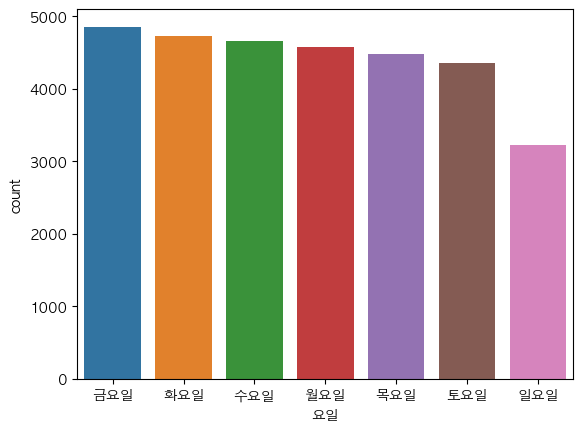

In [ ]:
sns.countplot(x='요일', data=X_train_drop_na, order=X_train_drop_na['요일'].value_counts().index)